# Notebook 2, Baseline Modeling and Seasonality Check

This notebook evaluates simple baseline forecasts that help us understand how predictable the rainfall and temperature time series are. These baselines will serve as reference points for later machine learning models. We use two baselines:

1. Naive model, prediction at time t equals value at time t-1.
2. Seasonal naive model, prediction for a given month equals the value from the same month in the previous year.

We compute RMSE and MAE for rainfall and temperature, and extract insights for feature engineering.


### Step 1: Load dataset and inspect structure
We load the cleaned dataset produced from Notebook 1 and confirm its shape and columns.


In [2]:
import pandas as pd

df = pd.read_csv("../4_data_analysis/model_datasets/model_ready_dataset.csv")
print(df.shape)
df.head()


(2040, 15)


,REGION,YEAR,Month,Rainfall,Temperature,Month_Num,Time,Rain_lag_1,Temp_lag_1,Rain_lag_2,Temp_lag_2,Rain_lag_3,Temp_lag_3,Rain_lag_12,Temp_lag_12
0,Central,1991,JAN,0.000000,22.685222,1,12,0.000000,27.665444,0.0,29.210333,0.387,32.436444,0.000,23.057667
1,Central,1991,FEB,0.000000,24.895333,2,13,0.000000,22.685222,0.0,27.665444,0.000,29.210333,0.000,22.018000
2,Central,1991,MAR,0.000000,27.808889,3,14,0.000000,24.895333,0.0,22.685222,0.000,27.665444,0.000,25.144778
3,Central,1991,APR,0.047333,33.137556,4,15,0.000000,27.808889,0.0,24.895333,0.000,22.685222,0.000,30.844667
4,Central,1991,MAY,0.216000,35.484000,5,16,0.047333,33.137556,0.0,27.808889,0.000,24.895333,0.002,33.960222


### Step 2: Check monthly seasonality
We compute the mean rainfall and temperature per month across all years and regions.
If the values follow a repeated yearly pattern, it indicates strong seasonality which justifies using month and seasonal baselines.


       Rainfall  Temperature
Month                       
APR    0.146248    30.433094
AUG    2.911341    30.195251
DEC    0.017576    23.245391
FEB    0.005873    24.610250
JAN    0.008913    22.711504
JUL    2.504989    31.167493
JUN    1.137382    32.691205
MAR    0.017979    27.733807
MAY    0.706145    32.329455
NOV    0.053143    25.867272
OCT    0.863102    29.116251
SEP    1.806930    30.400766


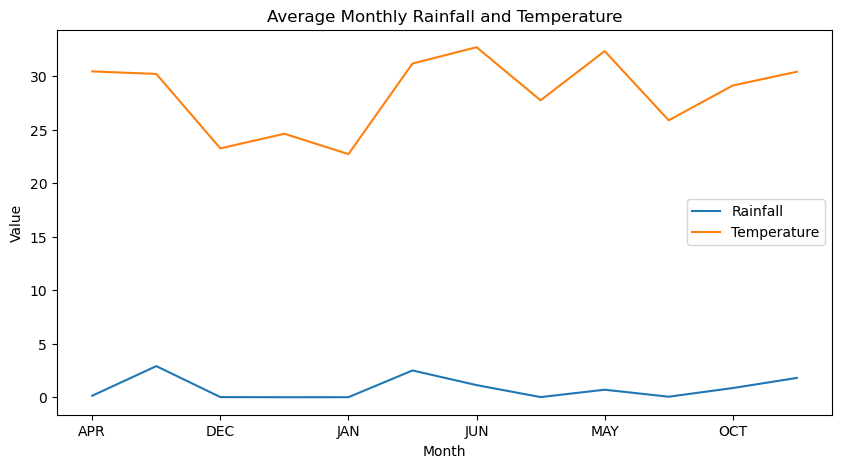

In [3]:
import matplotlib.pyplot as plt

monthly_means = df.groupby("Month")[["Rainfall", "Temperature"]].mean()

print(monthly_means)

monthly_means.plot(kind="line", figsize=(10,5))
plt.title("Average Monthly Rainfall and Temperature")
plt.ylabel("Value")
plt.show()


### Step 3: Naive baseline forecasting
The naive model predicts each value using the previous time step:
prediction[t] = actual[t minus 1]

This model is extremely simple, however it provides a lower bound that any ML model must beat. We compute RMSE and MAE for both rainfall and temperature.


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def compute_naive_baseline(df, target):
    # Ensure required columns are present
    required = ["REGION", "YEAR", "Month", target]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for baseline: {missing}")

    # Work on a sorted copy to avoid modifying original df
    df_sorted = df.sort_values(["REGION", "YEAR", "Month"]).copy()
    df_sorted["pred"] = df_sorted.groupby("REGION")[target].shift(1)
    valid = df_sorted.dropna(subset=["pred"])
    n = len(valid)
    if n == 0:
        return np.nan, np.nan, 0
    rmse = mean_squared_error(valid[target], valid["pred"], squared=False)
    mae = mean_absolute_error(valid[target], valid["pred"])
    return rmse, mae, n

naive_rain_rmse, naive_rain_mae, rain_n = compute_naive_baseline(df, "Rainfall")
naive_temp_rmse, naive_temp_mae, temp_n = compute_naive_baseline(df, "Temperature")

def _fmt_metric(val, n):
    if isinstance(val, float) and np.isnan(val):
        return f"insufficient data (n={n})"
    return f"{val:.3f} (n={n})"

print('Naive baseline (previous-step) results:')
print(f'- Rainfall: RMSE = {_fmt_metric(naive_rain_rmse, rain_n)}; MAE = {_fmt_metric(naive_rain_mae, rain_n)}')
print(f'- Temperature: RMSE = {_fmt_metric(naive_temp_rmse, temp_n)}; MAE = {_fmt_metric(naive_temp_mae, temp_n)}')


Naive baseline (previous-step) results:
- Rainfall: RMSE = 2.232 (n=2035); MAE = 1.295 (n=2035)
- Temperature: RMSE = 5.506 (n=2035); MAE = 4.202 (n=2035)


c:\Users\amhx1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\amhx1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Step 4: Seasonal naive baseline forecasting
The seasonal naive model predicts that each month repeats last year's value:
prediction[year Y, month m] = actual[year Y minus 1, month m]

This baseline is important because it captures seasonal structure that naive and even ML models may fail to reproduce.


In [7]:
def compute_seasonal_naive(df, target):
    df = df.sort_values(["REGION","YEAR","Month"])
    df["pred"] = df.groupby(["REGION","Month"])[target].shift(1)
    valid = df.dropna(subset=["pred"])
    rmse = mean_squared_error(valid[target], valid["pred"], squared=False)
    mae = mean_absolute_error(valid[target], valid["pred"])
    return rmse, mae

seasonal_rain_rmse, seasonal_rain_mae = compute_seasonal_naive(df, "Rainfall")
seasonal_temp_rmse, seasonal_temp_mae = compute_seasonal_naive(df, "Temperature")

seasonal_rain_rmse, seasonal_rain_mae, seasonal_temp_rmse, seasonal_temp_mae


c:\Users\amhx1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\amhx1\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.7770038175425381, 0.3637729677729678, 1.5437605135799577, 1.192190710391901)

### Step 5: Baseline performance comparison
We summarize the naive and seasonal naive models for both targets. These values determine what our ML model must outperform.


In [10]:
comparison = pd.DataFrame({
    "Model": ["Naive", "Naive", "Seasonal Naive", "Seasonal Naive"],
    "Target": ["Rainfall", "Temperature", "Rainfall", "Temperature"],
    "RMSE": [naive_rain_rmse, naive_temp_rmse, seasonal_rain_rmse, seasonal_temp_rmse],
    "MAE": [naive_rain_mae, naive_temp_mae, seasonal_rain_mae, seasonal_temp_mae]
})

comparison


,Model,Target,RMSE,MAE
0,Naive,Rainfall,2.232158,1.295419
1,Naive,Temperature,5.506120,4.201924
2,Seasonal Naive,Rainfall,0.777004,0.363773
3,Seasonal Naive,Temperature,1.543761,1.192191


### Step 6: Insights and next actions

### Key findings
1. The monthly averages confirm that both temperature and rainfall follow a clear seasonal pattern, especially temperature.
2. The seasonal naive baseline usually performs much better than the naive baseline. Any ML model must outperform the seasonal naive model to be considered useful.
3. These results imply that month, seasonal cycles, and lag features should be included in the feature engineering process.

### What we do next
We proceed to Notebook 3 to:
- Create lag features [lags are previous time steps that provide memory of the series].
- Add seasonal features such as month and region.
- Split the data for ML forecasting.
